In [1]:
%matplotlib inline
import numpy as np
import subprocess
from demtrack import load_gmat_track, track_analysis, moon_ellipsoid, reference_lla
import pymap3d
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import demtrack

In [2]:
GMAT_PATH = '/home/daniel/GMAT/R2018a/bin/GMAT-R2018a'

In [3]:
default_ephemeris = np.array([4732.513327944151, -9248.717668594734, -9119.805117562035, 0.3134657779330213, 0.04491836395360671, -0.2145603059330872])

In [4]:
GMAT_SCRIPT_TEMPLATE = """
GMAT SolarSystem.EphemerisSource = 'DE421';
GMAT SolarSystem.SPKFilename = '../data/planetary_ephem/spk/DE421AllPlanets.bsp';

Create Spacecraft DSLWP_B;
GMAT DSLWP_B.DateFormat = UTCGregorian;
GMAT DSLWP_B.Epoch = '25 Jul 2019 02:30:00.000';
GMAT DSLWP_B.CoordinateSystem = LunaICRF;
GMAT DSLWP_B.DisplayStateType = Cartesian;
GMAT DSLWP_B.X = {};
GMAT DSLWP_B.Y = {};
GMAT DSLWP_B.Z = {};
GMAT DSLWP_B.VX = {};
GMAT DSLWP_B.VY = {};
GMAT DSLWP_B.VZ = {};
GMAT DSLWP_B.DryMass = 45;
GMAT DSLWP_B.DragArea = 0.25;
GMAT DSLWP_B.SRPArea = 0.25;

Create ForceModel LunaProp_ForceModel;
GMAT LunaProp_ForceModel.CentralBody = Luna;
GMAT LunaProp_ForceModel.PrimaryBodies = {{Luna}};
GMAT LunaProp_ForceModel.PointMasses = {{Earth, Jupiter, Mars, Neptune, Saturn, Sun, Uranus, Venus}};
GMAT LunaProp_ForceModel.Drag = None;
GMAT LunaProp_ForceModel.SRP = On;
GMAT LunaProp_ForceModel.RelativisticCorrection = On;
GMAT LunaProp_ForceModel.GravityField.Luna.Degree = 10;
GMAT LunaProp_ForceModel.GravityField.Luna.Order = 10;
GMAT LunaProp_ForceModel.GravityField.Luna.PotentialFile = 'LP165P.cof';

Create Propagator LunaPropFine;
GMAT LunaPropFine.FM = LunaProp_ForceModel;
GMAT LunaPropFine.Type = PrinceDormand78;
GMAT LunaPropFine.InitialStepSize = 1;
GMAT LunaPropFine.Accuracy = 1e-13;
GMAT LunaPropFine.MinStep = 1;
GMAT LunaPropFine.MaxStep = 1;
GMAT LunaPropFine.MaxStepAttempts = 50;
GMAT LunaPropFine.StopIfAccuracyIsViolated = true;

Create Propagator LunaPropCoarse;
GMAT LunaPropCoarse.FM = LunaProp_ForceModel;
GMAT LunaPropCoarse.Type = PrinceDormand78;
GMAT LunaPropCoarse.InitialStepSize = 10;
GMAT LunaPropCoarse.Accuracy = 1e-13;
GMAT LunaPropCoarse.MinStep = 1;
GMAT LunaPropCoarse.MaxStep = 60;
GMAT LunaPropCoarse.MaxStepAttempts = 50;
GMAT LunaPropCoarse.StopIfAccuracyIsViolated = true;

Create CoordinateSystem LunaICRF;
GMAT LunaICRF.Origin = Luna;
GMAT LunaICRF.Axes = ICRF;

Create CoordinateSystem LunaFixed;
GMAT LunaFixed.Origin = Luna;
GMAT LunaFixed.Axes = BodyFixed;

Create ReportFile ReportFile1;
GMAT ReportFile1.Filename = '/tmp/crash_montecarlo.txt';
GMAT ReportFile1.Add = {{DSLWP_B.UTCModJulian, DSLWP_B.LunaFixed.X, DSLWP_B.LunaFixed.Y, DSLWP_B.LunaFixed.Z}};
GMAT ReportFile1.WriteHeaders = false;

BeginMissionSequence;
Toggle ReportFile1 Off;
Propagate LunaPropCoarse(DSLWP_B) {{DSLWP_B.Luna.Altitude = 20}};
Propagate LunaPropFine(DSLWP_B) {{DSLWP_B.Luna.Altitude = 10}};
Toggle ReportFile1 On;
Propagate LunaPropFine(DSLWP_B) {{DSLWP_B.Luna.Altitude = -10}};
"""

def run_gmat(ephemeris):
    SCRIPT_PATH = '/tmp/gmat.script'
    with open(SCRIPT_PATH, 'w') as f:
        f.write(GMAT_SCRIPT_TEMPLATE.format(*ephemeris))
    subprocess.call([GMAT_PATH, '-x', '-m', '-r', SCRIPT_PATH])

In [5]:
def montecarlo(sigma_x = 1, sigma_v = 0):
    ephemeris_error = np.concatenate((sigma_x*np.random.randn(3), sigma_v*np.random.randn(3)))
    run_gmat(default_ephemeris + ephemeris_error)
    return track_analysis(load_gmat_track('/tmp/crash_montecarlo.txt'), only_compute_impact = True)

In [6]:
def run_montecarlo(output_file, sigma_x = 1, sigma_v = 0):
    f = open(output_file, 'w')
    while True:
        point = montecarlo(sigma_x, sigma_v)
        f.write(', '.join(map(str, point)) + '\n')
        f.flush()

In [7]:
# Run to regenerate results file
#run_montecarlo('crash_montecarlo_1km_0ms.txt')

In [8]:
points = np.loadtxt('crash_montecarlo_1km_0ms.txt', delimiter = ',')
print('read', points.shape[0], 'points')

read 2016 points


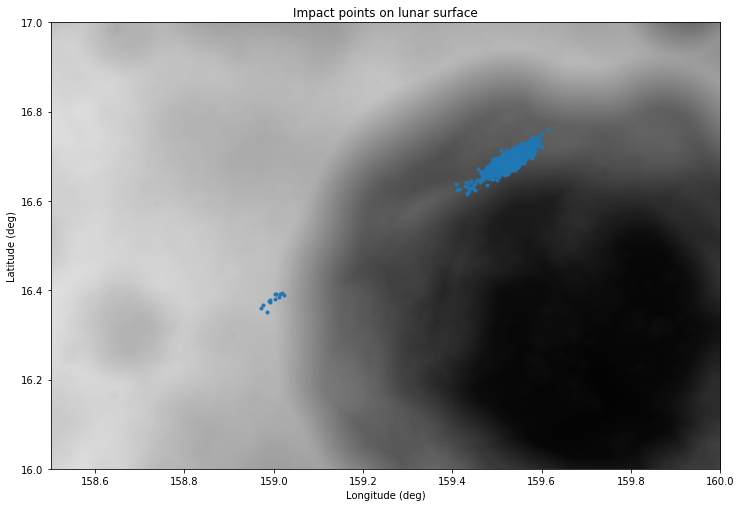

In [9]:
plt.figure(figsize = (12,12), facecolor = 'w')
plt.imshow(demtrack.dem, extent = demtrack.dem_extent, origin = 'bottom', cmap = 'gray')
plt.plot(points[:,1], points[:,0], '.')
plt.title('Impact points on lunar surface')
plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')
plt.xlim((158.5,160))
plt.ylim((16,17));

In [10]:
points_enu = np.array(pymap3d.geodetic2enu(points[:,0], points[:,1], points[:,2], reference_lla[0], reference_lla[1], reference_lla[2], ell = moon_ellipsoid))

In [11]:
outliers = np.sqrt(np.sum(points_enu[:2,:]**2, axis = 0)) > 7e3
np.average(outliers)

0.006448412698412698

In [12]:
np.average(points_enu[:,~outliers], axis = 1)

array([81.61371435, 48.58710178, -4.26942485])

In [13]:
Sigma = np.cov(points_enu[:2,~outliers])
l, v = np.linalg.eig(Sigma)
print(np.sqrt(l))
heading = np.rad2deg(np.arctan2(v[0,0], v[1,0]))
print(heading)

[875.75137892 238.82060938]
57.626145316101834


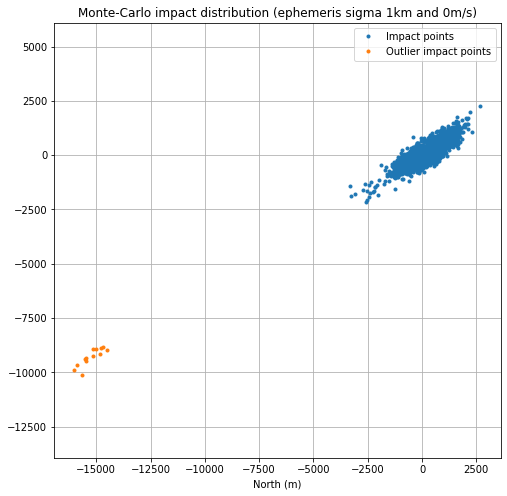

In [14]:
plt.figure(figsize = (8,8), facecolor = 'w')
a = plt.subplot(111)
a.plot(points_enu[0,~outliers], points_enu[1,~outliers], '.', label = 'Impact points')
a.plot(points_enu[0,outliers], points_enu[1,outliers], '.', label = 'Outlier impact points')
a.axis('equal')
plt.xlabel('East (m)')
plt.xlabel('North (m)')
plt.title('Monte-Carlo impact distribution (ephemeris sigma 1km and 0m/s)')
plt.grid()
plt.legend();

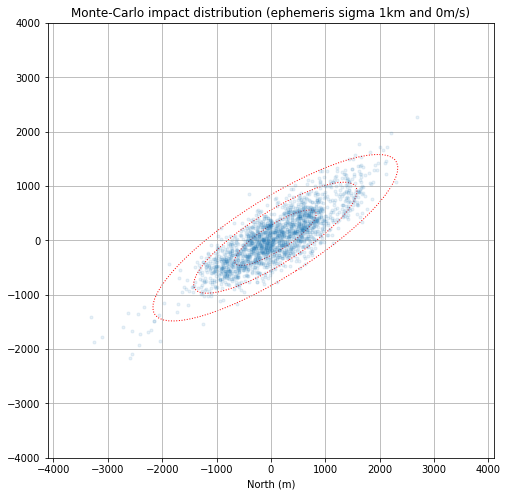

In [15]:
plt.figure(figsize = (8,8), facecolor = 'w')
a = plt.subplot(111)
a.plot(points_enu[0,:], points_enu[1,:], '.', alpha = 0.1)
for sigma in np.arange(1,4):
    a.add_artist(Ellipse(np.average(points_enu[:2,~outliers], axis = 1),
                         2 * sigma * np.sqrt(l[0]), 2 * sigma * np.sqrt(l[1]),
                         90-heading,
                         facecolor = 'none', edgecolor = 'red', linestyle = ':'))
a.axis('equal')
plt.xlabel('East (m)');
plt.xlabel('North (m)')
plt.title('Monte-Carlo impact distribution (ephemeris sigma 1km and 0m/s)')
plt.xlim((-4000,4000))
plt.ylim((-4000,4000))
plt.grid();